In [1]:
# ## Simulation parameters
exp_name = 'exp-FINAL'
eps = 0.10
eps_str = '0_1'

run_idx_length = 1_000
N_val = 1_000
runs = 50

In [ ]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial']
%config InlineBackend.figure_formats = ['svg']

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics
import itertools

import joblib
from joblib import Parallel, delayed

In [35]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
})

In [5]:
from OPE_utils_new import (
    format_data_tensor,
    policy_eval_analytic_finite,
    OPE_IS_h,
    compute_behavior_policy_h,
)

In [6]:
def policy_eval_helper(π):
    V_H = policy_eval_analytic_finite(P.transpose((1,0,2)), R, π, gamma, H)
    Q_H = [(R + gamma * P.transpose((1,0,2)) @ V_H[h]) for h in range(1,H)] + [R]
    J = isd @ V_H[0]
    # Check recursive relationships
    assert len(Q_H) == H
    assert len(V_H) == H
    assert np.all(Q_H[-1] == R)
    assert np.all(np.sum(π * Q_H[-1], axis=1) == V_H[-1])
    assert np.all(R + gamma * P.transpose((1,0,2)) @ V_H[-1] == Q_H[-2])
    return V_H, Q_H, J

In [7]:
def iqm(x):
    return scipy.stats.trim_mean(x, proportiontocut=0.25, axis=None)

In [8]:
NSTEPS = H = 20   # max episode length in historical data # Horizon of the MDP
G_min = -1        # the minimum possible return
G_max =  1        # the maximum possible return
nS, nA = 1442, 8

PROB_DIAB = 0.2

In [9]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [10]:
# Precomputed optimal policy
π_star = joblib.load('../data/π_star.joblib')

## Policies

In [11]:
# vaso unif, mv abx optimal
π_unif = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)

### Behavior policy

In [12]:
# vaso eps=0.5, mv abx optimal
π_beh = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
π_beh[π_star == 1] = 1-eps
π_beh[π_beh == 0.5] = eps

In [13]:
V_H_beh, Q_H_beh, J_beh = policy_eval_helper(π_beh)
J_beh

0.25038354793851164

### Optimal policy

In [14]:
V_H_star, Q_H_star, J_star = policy_eval_helper(π_star)
J_star

0.40877179296760224

### flip action for x% states

In [15]:
def get_π_flip(pol_flip_seed, pol_flip_num):
    rng_flip = np.random.default_rng(pol_flip_seed)
    flip_states = rng_flip.choice(range(1440), pol_flip_num, replace=False)

    π_tmp = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
    π_flip = π_tmp.copy()
    π_flip[π_tmp == 0.5] = 0
    π_flip[π_star == 1] = 1
    for s in flip_states:
        π_flip[s, π_tmp[s] == 0.5] = 1
        π_flip[s, π_star[s] == 1] = 0
    assert π_flip.sum(axis=1).mean() == 1
    return π_flip

In [16]:
πs_flip_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        π_flip = get_π_flip(flip_seed, flip_num)
        πs_flip_list.append(π_flip)

In [17]:
v_list = []
for π_eval in tqdm(πs_flip_list):
    _, _, J_eval = policy_eval_helper(π_eval)
    v_list.append(J_eval)

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:20<00:00,  1.24it/s]


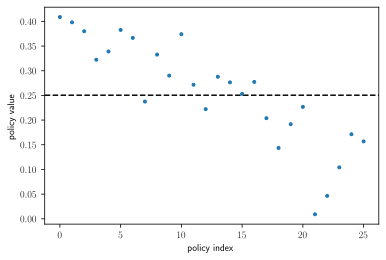

In [18]:
plt.plot(v_list, ls='none', marker='.')
plt.axhline(J_beh, c='k', ls='--', label='behavior', zorder=0)
plt.xlabel('policy index')
plt.ylabel('policy value')
plt.show()

## Load results

In [19]:
df_results_0 = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-observed.csv')

In [20]:
dfs_results_orig_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-{pol_name}-orig.csv')
        dfs_results_orig_list.append(df_results_)

In [21]:
dfs_results_annotEval_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotEval.csv')
        dfs_results_annotEval_list.append(df_results_)

In [22]:
dfs_results_annotBeh_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotBeh.csv')
        dfs_results_annotBeh_list.append(df_results_)

In [23]:
dfs_results_annotBehConvertedAM_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotBehConvertedAM.csv')
        dfs_results_annotBehConvertedAM_list.append(df_results_)

### Expected state distribution under π_b

In [24]:
input_dir = f'../datagen/vaso_eps_{eps_str}-100k/'
def load_data(fname):
    print('Loading data', fname, '...', end='')
    df_data = pd.read_csv('{}/{}'.format(input_dir, fname)).rename(columns={'State_idx': 'State'})#[['pt_id', 'Time', 'State', 'Action', 'Reward']]

    # Assign next state
    df_data['NextState'] = [*df_data['State'].iloc[1:].values, -1]
    df_data.loc[df_data.groupby('pt_id')['Time'].idxmax(), 'NextState'] = -1
    df_data.loc[(df_data['Reward'] == -1), 'NextState'] = 1440
    df_data.loc[(df_data['Reward'] == 1), 'NextState'] = 1441

    assert ((df_data['Reward'] != 0) == (df_data['Action'] == -1)).all()

    print('DONE')
    return df_data

df_seed2 = load_data('2-features.csv') # va

Loading data 2-features.csv ...DONE


In [25]:
state_dist = df_seed2['State'].value_counts().reindex(range(nS), fill_value=0)

## Plots

In [26]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1-y2)))

In [27]:
def kl_divergence(p, q):
    p_pnz, q_pnz = p[p != 0], q[p != 0]
    return np.sum(p_pnz * np.log(p_pnz) - np.log(q_pnz), 0)

In [52]:
rmse_dict = {}
stderr_dict = {}
for name, dfs_results_list in {
    'orig': dfs_results_orig_list,
    'annotEval': dfs_results_annotEval_list, 
    'annotBeh': dfs_results_annotBeh_list,
    'annotBehConvertedAM': dfs_results_annotBehConvertedAM_list,
}.items():
    rmse_list = []
    stderr_list = []
    for idx, π_idx in enumerate(πs_flip_list):
        J_eval = v_list[idx]
        df_results = dfs_results_list[idx]
        v_IS, v_WIS = list(df_results['IS_value']), list(df_results['WIS_value'])
        rmse_value = rmse(v_IS + v_WIS, J_eval)
        rmse_list.append(rmse_value)
        stderr_value = np.std(v_IS + v_WIS - J_eval)
        stderr_list.append(stderr_value)
        
    rmse_dict[name] = rmse_list
    stderr_dict[name] = stderr_list

In [29]:
kl_list = []
for idx, π_idx in enumerate(πs_flip_list):
    kl_ = [kl_divergence(πe_s, πb_s) for πb_s, πe_s in zip(π_beh, π_idx)]
    kl_list.append(np.average(kl_, weights=state_dist))

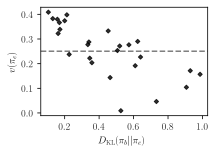

In [48]:
fig, ax = plt.subplots(figsize=(3,2))
plt.plot(kl_list, v_list, ls='none', marker='D', c='k', markersize=3, alpha=0.8)
plt.axhline(J_beh, c='gray', ls='--', label='behavior', zorder=0)
plt.xlabel('$D_{\mathrm{KL}}(\pi_b || \pi_e)$')
plt.ylabel('$v(\pi_e)$')
plt.show()

In [58]:
pd.DataFrame([rmse_dict['annotEval'], stderr_dict['annotEval']]).T

,0,1
0,0.013015,0.012592
1,0.013003,0.012563
2,0.013630,0.013513
3,0.013515,0.013259
4,0.013844,0.013433
5,0.013478,0.013025
6,0.013505,0.013314
7,0.010473,0.010330
8,0.012240,0.012103
9,0.011505,0.011412


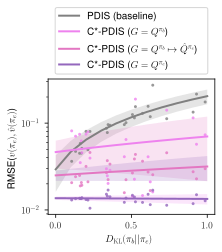

In [84]:
fig, ax = plt.subplots(figsize=(3,2.5))
x = kl_list
y1 = rmse_dict['orig']
y2 = rmse_dict['annotEval']
y3 = rmse_dict['annotBeh']
y4 = rmse_dict['annotBehConvertedAM']

w1, cov1 = np.polyfit(x, y1, 1, cov=True)
e1 = np.sqrt(np.diag(cov1))
w2, cov2 = np.polyfit(x, y2, 1, cov=True)
e2 = np.sqrt(np.diag(cov2))
w3, cov3 = np.polyfit(x, y3, 1, cov=True)
e3 = np.sqrt(np.diag(cov3))
w4, cov4 = np.polyfit(x, y4, 1, cov=True)
e4 = np.sqrt(np.diag(cov4))

x0 = np.arange(0,1.1,0.1)
plt.plot(x, y1, ls='none', marker='.', mew=0, c='gray', alpha=0.8)
plt.plot(x, y3, ls='none', marker='.', mew=0, c='violet', alpha=0.8)
plt.plot(x, y4, ls='none', marker='.', mew=0, c='tab:pink', alpha=0.8)
plt.plot(x, y2, ls='none', marker='.', mew=0, c='tab:purple', alpha=0.8)
plt.plot(x0, np.poly1d(w1)(x0), ls='-', lw=2, c='gray', label='PDIS (baseline)')
plt.plot(x0, np.poly1d(w3)(x0), ls='-', lw=2, c='violet', label='C*-PDIS ($G = Q^{\pi_b}$)')
plt.plot(x0, np.poly1d(w4)(x0), ls='-', lw=2, c='tab:pink', label='C*-PDIS ($G = Q^{\pi_b} \mapsto \hat{Q}^{\pi_e}$)')
plt.plot(x0, np.poly1d(w2)(x0), ls='-', lw=2, c='tab:purple', label='C*-PDIS ($G = Q^{\pi_e}$)')
plt.fill_between(x0, np.poly1d(w1-e1)(x0), np.poly1d(w1+e1)(x0), fc='gray', alpha=0.2)
plt.fill_between(x0, np.poly1d(w2-e2)(x0), np.poly1d(w2+e2)(x0), fc='violet', alpha=0.2)
plt.fill_between(x0, np.poly1d(w3-e3)(x0), np.poly1d(w3+e3)(x0), fc='tab:pink', alpha=0.2)
plt.fill_between(x0, np.poly1d(w4-e4)(x0), np.poly1d(w4+e4)(x0), fc='tab:purple', alpha=0.2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5,1.0), labelspacing=0.6)
plt.xticks([0,0.5,1])
plt.xlabel('$D_{\mathrm{KL}}(\pi_b || \pi_e)$')
plt.ylabel('RMSE($v(\pi_e),\hat{v}(\pi_e)$)')
plt.savefig('fig/annot_KL.pdf', bbox_inches='tight')
plt.yscale('log')
plt.savefig('fig/annot_KL_logscale.pdf', bbox_inches='tight')
plt.show()

solve for best-fit line with zero intercept

In [92]:
df_results_onpolicy = pd.read_csv(f'./results/{exp_name}/vaso_eps_{eps_str}-onpolicy-orig.csv')
rmse_value_onpolicy = rmse(list(df_results_onpolicy['IS_value']) + list(df_results_onpolicy['WIS_value']), J_beh)

In [125]:
df_results_onpolicy_annotBeh = pd.read_csv(f'./results/{exp_name}a/vaso_eps_{eps_str}-onpolicy-aug_step-annotBeh.csv')
rmse_value_onpolicy_annotBeh = rmse(list(df_results_onpolicy_annotBeh['IS_value']) + list(df_results_onpolicy_annotBeh['WIS_value']), J_beh)

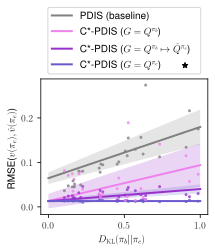

In [143]:
fig, ax = plt.subplots(figsize=(3,2.5))
x = kl_list
y1 = rmse_dict['orig']
y2 = rmse_dict['annotEval']
y3 = rmse_dict['annotBeh']
y4 = rmse_dict['annotBehConvertedAM']

w1, cov1 = np.polyfit(x, y1, 1, cov=True)
e1 = np.sqrt(np.diag(cov1))
w2, cov2 = np.polyfit(x, y2, 1, cov=True)
e2 = np.sqrt(np.diag(cov2))
w3, cov3 = np.polyfit(x, y3, 1, cov=True)
e3 = np.sqrt(np.diag(cov3))
w4, cov4 = np.polyfit(x, y4, 1, cov=True)
e4 = np.sqrt(np.diag(cov4))

w1_, _, _, _ = np.linalg.lstsq(np.array(x)[:,np.newaxis], np.array(y1)-rmse_value_onpolicy, rcond=None)
w2_, _, _, _ = np.linalg.lstsq(np.array(x)[:,np.newaxis], np.array(y2)-rmse_value_onpolicy_annotBeh, rcond=None)
w3_, _, _, _ = np.linalg.lstsq(np.array(x)[:,np.newaxis], np.array(y3)-rmse_value_onpolicy_annotBeh, rcond=None)
w4_, _, _, _ = np.linalg.lstsq(np.array(x)[:,np.newaxis], np.array(y4)-rmse_value_onpolicy_annotBeh, rcond=None)
w1__ = np.array([w1_[0], rmse_value_onpolicy])
w2__ = np.array([w2_[0], rmse_value_onpolicy_annotBeh])
w2__ = np.array([0, rmse_value_onpolicy_annotBeh])
w3__ = np.array([w3_[0], rmse_value_onpolicy_annotBeh])
w4__ = np.array([w4_[0], rmse_value_onpolicy_annotBeh])


x0 = np.arange(0,1.1,0.1)
plt.plot(x0, np.poly1d(w1__)(x0), ls='-', lw=2, c='gray', label='PDIS (baseline)')
plt.plot(x0, np.poly1d(w3__)(x0), ls='-', lw=2, c='violet', label='C*-PDIS ($G = Q^{\pi_b}$)')
plt.plot(x0, np.poly1d(w4__)(x0), ls='-', lw=2, c='darkorchid', label='C*-PDIS ($G = Q^{\pi_b} \mapsto \hat{Q}^{\pi_e}$)')
plt.plot(x0, np.poly1d(w2__)(x0), ls='-', lw=2, c='slateblue', label='C*-PDIS ($G = Q^{\pi_e}$)')
plt.fill_between(x0, np.poly1d(w1__-e1)(x0), np.poly1d(w1__+e1)(x0), fc='gray', alpha=0.2)
plt.fill_between(x0, np.poly1d(w2__-e2)(x0), np.poly1d(w2__+e2)(x0), fc='violet', alpha=0.2)
plt.fill_between(x0, np.poly1d(w3__-e3)(x0), np.poly1d(w3__+e3)(x0), fc='darkorchid', alpha=0.2)
plt.fill_between(x0, np.poly1d(w4__-e4)(x0), np.poly1d(w4__+e4)(x0), fc='slateblue', alpha=0.2)
plt.plot(x, y2, ls='none', marker='.', mew=0, c='slateblue', alpha=0.8)
plt.plot(x, y4, ls='none', marker='.', mew=0, c='darkorchid', alpha=0.8)
plt.plot(x, y3, ls='none', marker='.', mew=0, c='violet', alpha=0.8)
plt.plot(x, y1, ls='none', marker='.', mew=0, c='gray', alpha=0.8)
ylim = ax.get_ylim()
plt.plot(0.9, 0.318, marker='*', c='k', clip_on=False, zorder=100)
plt.ylim(ylim)
plt.legend(loc='lower center', bbox_to_anchor=(0.5,1.0), labelspacing=0.6)
plt.xticks([0,0.5,1])
plt.xlabel('$D_{\mathrm{KL}}(\pi_b || \pi_e)$')
plt.ylabel('RMSE($v(\pi_e),\hat{v}(\pi_e)$)')
plt.savefig('fig/annot_KL_0.pdf', bbox_inches='tight')
# plt.yscale('log')
# plt.savefig('fig/annot_KL_logscale_0.pdf', bbox_inches='tight')
plt.show()